# Evaluation

In [1]:
import torch
import matplotlib.pyplot as plt
import pickle
from scipy.stats import pearsonr
import pandas as pd
from src import utils
import seaborn as sns
import numpy as np
from matplotlib.transforms import Affine2D
import os
import random

utils.plot_style()
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)
os.makedirs('plots/', exist_ok=True)

In [2]:
intensity_scales = [100, 300]
n_cells_list = [1, 2, 3, 5, 10, 15, 20]
n_datasets = 10

## Independent models

In [3]:
df_list = []

for dataset in range(n_datasets):
    for intensity_scale in intensity_scales:
        data = torch.load('../../data/simulated/data/shared/{}_{}.pt'.format(dataset, intensity_scale))
        for cell in range(max(n_cells_list)):
            z_data = data['z'][cell]
            w_data = data['w']

            results = pickle.load(open('results/independent/{}_{}_{}/final/latents.pkl'.format(dataset, intensity_scale, cell), 'rb'))
            z = results['z'][0]
            z = torch.nan_to_num(z, 0)
            z /= z.flatten(start_dim=1).max(dim=-1)[0].view(data['n_factors'], 1, 1)
            w = results['w']
            w /= w.max(dim=0)[0].view(1, data['n_factors'])

            inds, _ = utils.optimal_assignment(z_data, z, 0)

            z = z[inds]
            w = w[:, inds]

            z_corr = pearsonr(z.flatten(), z_data.flatten())[0]
            w_corr = pearsonr(w.flatten(), w_data.flatten())[0]

            df_list.append(pd.DataFrame({
                'model' : 'independent',
                'dataset' : dataset,
                'intensity_scale' : intensity_scale,
                'cell' : cell,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
                'n_cells' : 1,
            }, index=[0]))

independent_evaluation = pd.concat(df_list)

## Multicell models

In [4]:
df_list = []

for dataset in range(n_datasets):
    for intensity_scale in intensity_scales:
        data = torch.load('../../data/simulated/data/shared/{}_{}.pt'.format(dataset, intensity_scale))
        z_data = data['z']
        w_data = data['w']

        for n_cells in n_cells_list[1:]:
            results = pickle.load(open('results/multicell/{}_{}_{}/final/latents.pkl'.format(dataset, intensity_scale, n_cells), 'rb'))
            z = results['z']
            z = torch.nan_to_num(z, 0)
            z /= z.flatten(start_dim=2).max(dim=-1)[0].view(n_cells, data['n_factors'], 1, 1)
            z = torch.nan_to_num(z, 0)
            w = results['w']
            w /= w.max(dim=0)[0].view(1, data['n_factors'])
            w = torch.nan_to_num(w, 0)

            inds, _ = utils.optimal_assignment(z_data[:n_cells], z, 1)

            z = z[:, inds]
            w = w[:, inds]

            for cell in range(n_cells):
                z_corr = pearsonr(z[cell].flatten(), z_data[cell].flatten())[0]
                w_corr = pearsonr(w.flatten(), w_data.flatten())[0]

                df_list.append(pd.DataFrame({
                    'model' : 'multicell',
                    'dataset' : dataset,
                    'intensity_scale' : intensity_scale,
                    'w_corr' : w_corr,
                    'z_corr' : z_corr,
                    'cell' : cell,
                    'n_cells' : n_cells,
                }, index=[0]))

multicell_evaluation = pd.concat(df_list)

multicell_evaluation = pd.concat([multicell_evaluation, independent_evaluation.query('cell==0')])

## Plots

In [5]:
df = []

for intensity_scale in intensity_scales:
    data = []
    for dataset in range(n_datasets):
        data.append(torch.load('../../data/simulated/data/shared/{}_{}.pt'.format(dataset, intensity_scale))['coordinates'])
    data = pd.concat(data)
    df.append(pd.DataFrame({
        'intensity_scale' : intensity_scale,
        'avg_n_molecules' : data.shape[0] / (data['gene'].unique().size * data['cell'].unique().size)
    }, index=[0]))

avg_n_molecules = pd.concat(df).avg_n_molecules.values

In [6]:
df_list = []

for intensity_scale in intensity_scales:
    for n_cells in n_cells_list:
        independent_evaluation_subset = independent_evaluation[(independent_evaluation.cell<n_cells) & (independent_evaluation.intensity_scale==intensity_scale)]
        independent_evaluation_subset = independent_evaluation_subset.groupby('dataset')[['w_corr', 'z_corr']].mean().reset_index()
        independent_evaluation_subset['n_cells'] = n_cells
        independent_evaluation_subset['model'] = 'independent'
        independent_evaluation_subset['intensity_scale'] = intensity_scale
        df_list.append(independent_evaluation_subset)

        multicell_evaluation_subset = multicell_evaluation[(multicell_evaluation.n_cells==n_cells) & (multicell_evaluation.intensity_scale==intensity_scale)]
        multicell_evaluation_subset = multicell_evaluation_subset.groupby('dataset')[['w_corr', 'z_corr']].mean().reset_index()
        multicell_evaluation_subset['n_cells'] = n_cells
        multicell_evaluation_subset['model'] = 'multicell'
        multicell_evaluation_subset['intensity_scale'] = intensity_scale
        df_list.append(multicell_evaluation_subset)

evaluation = pd.concat(df_list)

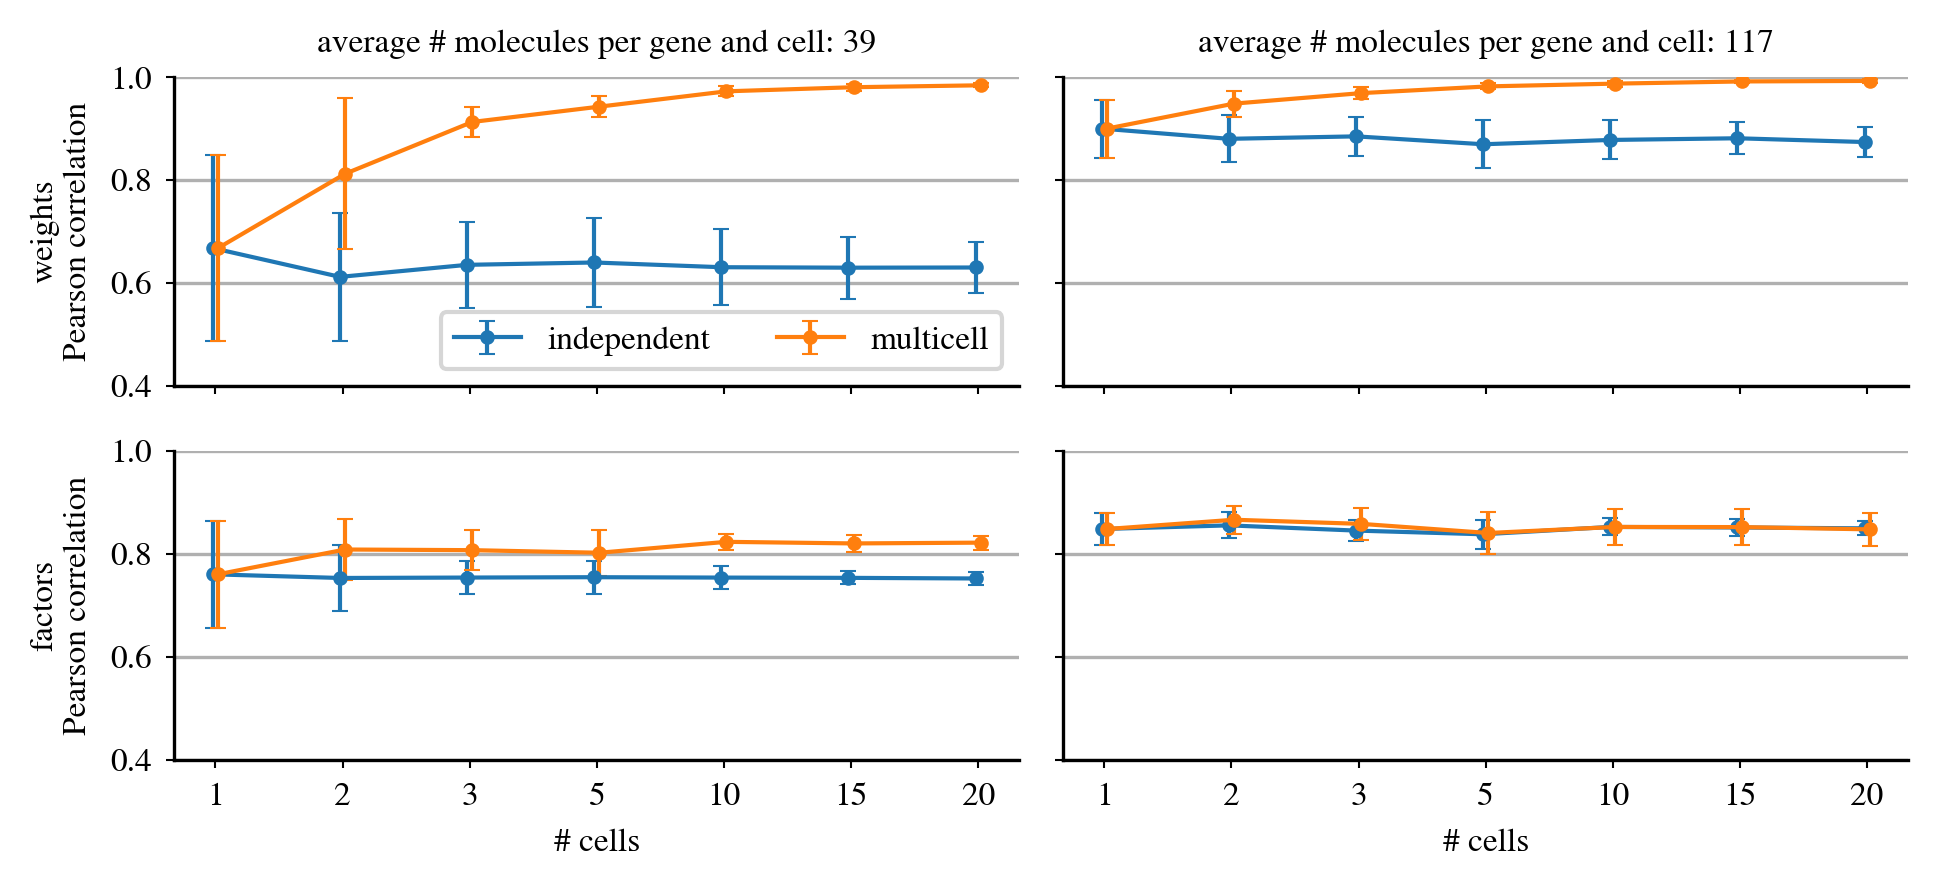

In [11]:
fig, axs = plt.subplots(len(intensity_scales), 2, figsize=(6.5, 3), sharex=True, sharey=True, dpi=300)

for i, ax in enumerate(axs.flatten()):
    ax.set_xticks(np.arange(len(evaluation.n_cells.unique())))
    ax.set_xticklabels(evaluation.n_cells.unique())
    ax.set_ylim([0.4, 1])
    ax.grid(axis='y')
    ax.spines[['right', 'top']].set_visible(False)

for i, intensity_scale in enumerate(intensity_scales):
    for j, latent in enumerate(['w_corr', 'z_corr']):
        for k, model in enumerate(['independent', 'multicell']):
            trans1 = Affine2D().translate(-0.02, 0.0) + axs[j, i].transData
            trans2 = Affine2D().translate(+0.02, 0.0) + axs[j, i].transData
            axs[j, i].errorbar(
                x=np.arange(len(evaluation.n_cells.unique())),
                y=evaluation[(evaluation.intensity_scale==intensity_scale) & (evaluation.model==model)].groupby('n_cells')[latent].mean().values,
                yerr=evaluation[(evaluation.intensity_scale==intensity_scale) & (evaluation.model==model)].groupby('n_cells')[latent].std().values,
                marker='o',
                markersize=3,
                linewidth=1.,
                capsize=2,
                markeredgewidth=0.5,
                transform=[trans1, trans2][k],
                label=model,
                )

axs[0, 0].set_ylabel('weights\nPearson correlation')
axs[1, 0].set_ylabel('factors\nPearson correlation')
axs[0, 0].set_title('average # molecules per gene and cell: {}'.format(round(avg_n_molecules[0])))
axs[0, 1].set_title('average # molecules per gene and cell: {}'.format(round(avg_n_molecules[1])))
axs[1, 0].set_xlabel('# cells')
axs[1, 1].set_xlabel('# cells')
axs[0, 0].legend(ncol=2)
        
plt.tight_layout()
plt.savefig('plots/multicell.svg')